- plot different svm class on iris
- SVM: seperating hyperplane for unbalanced classes
- SVM: weighted samples
- SVM: custom kernel
- SVM: margins example
- plot support vectors in LinearSVC


# Plot different SVM classifiers in the iris dataset

Comparison of different linear SVM classifiers on a 2D projection of the iris dataset. We only consider the first 2 features of this dataset:
- Sepal length
- Sepal width

This example shows how to plot the decision surface for four SVM classifiers with different kernels.

The linear models LinearSVC() and SVC(kernel='linear') yield slightly different decision boundaries. This can be a consequence of the following differences:

- LinearSVC minimizes the squared hinge loss while SVC minimizes the regular hinge loss.
- LinearSVC uses the One-vs-All (also known as One-vs-Rest) multiclass reduction while SVC uses the One-vs-One multiclass reduction.
- Both linear models have linear decision boundaries (intersecting hyperplanes) while the non-linear kernel models (polynomial or Gaussian RBF) have more flexible non-linear decision boundaries with shapes that depend on the kind of kernel and its parameters.

> while plotting the decision function of classifiers for toy 2D datasets can help get an intuitive understanding of their respective expressive power, be aware that those intuitions don’t always generalize to more realistic high-dimensional problems.

In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

In [2]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)

models = (clf.fit(X, y) for clf in models)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


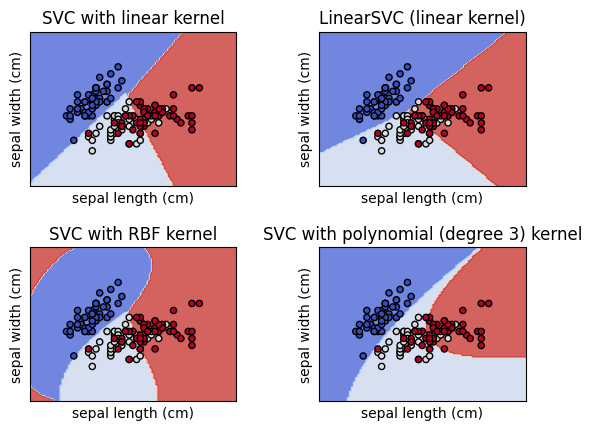

In [3]:
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

# SVM: Separating hyperplane for unbalanced classes

Find the optimal separating hyperplane using an SVC for classes that are unbalanced.

We first find the separating plane with a plain SVC and then plot (dashed) the separating hyperplane with automatically correction for unbalanced classes.


> This example will also work by replacing SVC(kernel="linear") with SGDClassifier(loss="hinge"). Setting the loss parameter of the SGDClassifier equal to hinge will yield behaviour such as that of a SVC with a linear kernel.



In [4]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

In [5]:
# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]

X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

X[0], y[0]

(array([2.64607852, 0.60023581]), 0)

In [6]:
# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

SVC(kernel='linear')

The `class_weight` parameter adjusts the importance of different classes in the model. In your code, `class_weight={1: 10}` tells the model to give 10 times more importance to class `1` than other classes, which helps the model pay more attention to the minority class, improving its performance on imbalanced datasets.

In [14]:
# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 10})
wclf.fit(X, y)

SVC(class_weight={1: 10}, kernel='linear')

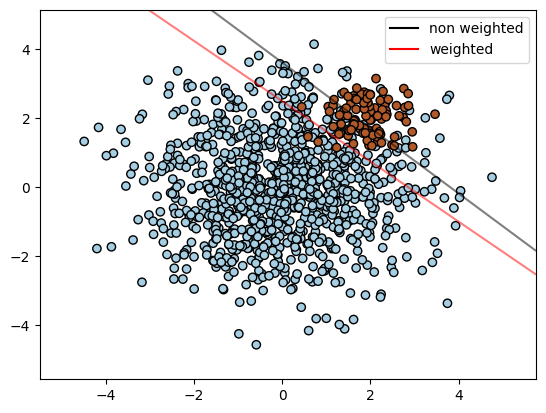

In [15]:
# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

# plot decision boundary and margins for weighted classes
wdisp = DecisionBoundaryDisplay.from_estimator(
    wclf,
    X,
    plot_method="contour",
    colors="r",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

plt.legend(
    [
        mlines.Line2D([], [], color="k", label="non weighted"),
        mlines.Line2D([], [], color="r", label="weighted"),
    ],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()

# SVM: Weighted samples

Plot decision function of a weighted dataset, where the size of points is proportional to its weight.

The sample weighting rescales the C parameter, which means that the classifier puts more emphasis on getting these points right. The effect might often be subtle. To emphasize the effect here, we particularly weight outliers, making the deformation of the decision boundary very visible.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)

In [18]:
# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10

sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))

# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

In [19]:
# Fit the models.
# This model does not take into account sample weights.
clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

SVC(gamma=1)

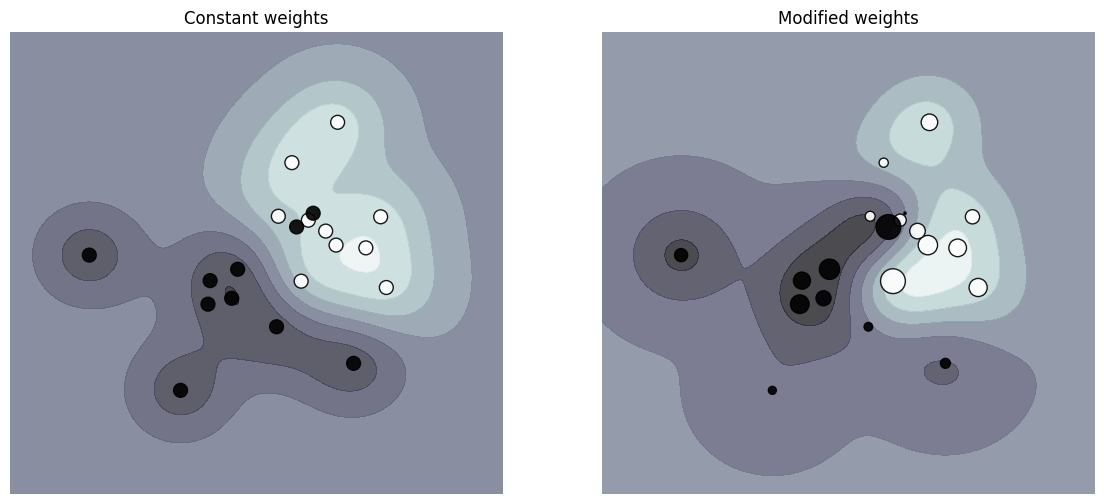

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(
    clf_no_weights, sample_weight_constant, axes[0], "Constant weights"
)
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1], "Modified weights")

plt.show()

# SVM: custom kernel

Simple usage of Support Vector Machines to classify a sample. It will plot the decision surface and the support vectors.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
# avoid this ugly slicing by using a two-dim dataset
Y = iris.target

In [22]:
def my_kernel(X, Y):
    """
    We create a custom kernel:

                 (2  0)
    k(X, Y) = X  (    ) Y.T
                 (0  1)
    """
    M = np.array([[2, 0], [0, 1.0]])
    return np.dot(np.dot(X, M), Y.T)


In [28]:
my_kernel

<function __main__.my_kernel(X, Y)>

In [16]:
h = 0.02  # step size in the mesh

# we create an instance of SVM and fit out data.
clf = svm.SVC(kernel=my_kernel)
clf.fit(X, Y)

SVC(kernel=<function my_kernel at 0x7a98d96727a0>)

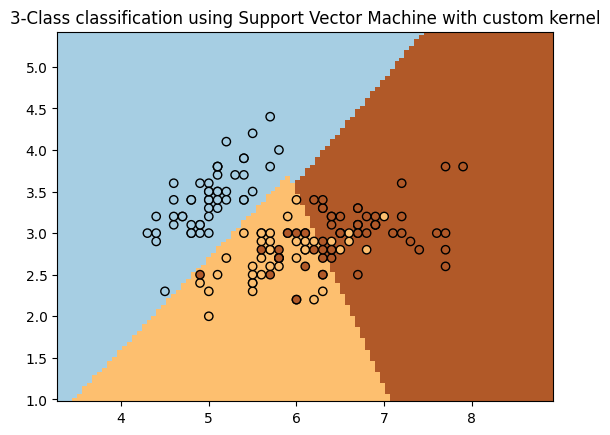

In [17]:
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.title("3-Class classification using Support Vector Machine with custom kernel")
plt.axis("tight")
plt.show()

# SVM: margins example

The plots below illustrate the effect the parameter C has on the separation line.

- A large value of C basically tells our model that we do not have that much faith in our data’s distribution, and will only consider points close to line of separation.

Large C (e.g., 1): The model tries to fit the training data as well as possible, which may lead to a smaller margin and fewer support vectors on the boundary.

- A small value of C includes more/all the observations, allowing the margins to be calculated using all the data in the area.

Small C (e.g., 0.05): The model has more regularization, which means it will allow some misclassification to achieve a larger margin, leading to a broader decision boundary that includes more points in the margin.

In [30]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm

# we create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

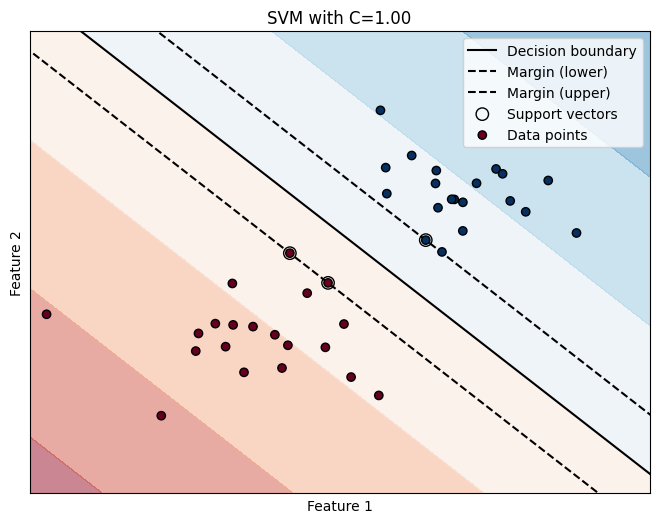

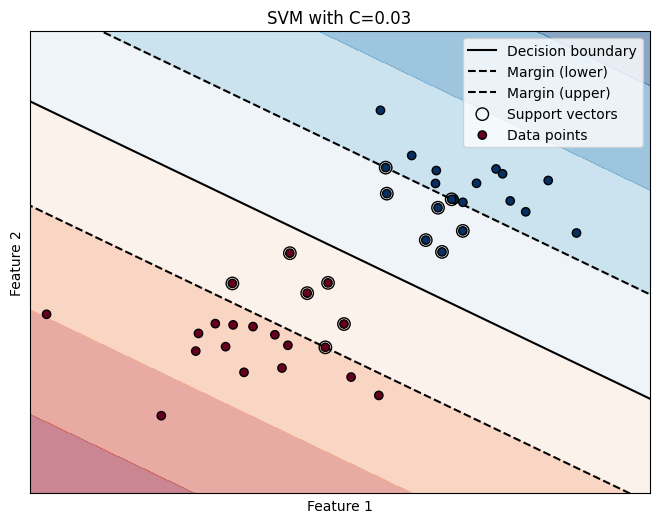

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# Data preparation (assuming X and Y are already defined)
# X: feature matrix
# Y: target labels

# Initial figure number
fignum = 1

# Define different values for the regularization parameter C
for name, penalty in (("unreg", 1), ("reg", 0.03)):
    # Create and fit the SVM model with a linear kernel
    clf = svm.SVC(kernel="linear", C=penalty)
    clf.fit(X, Y)

    # Extract the coefficients of the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]  # Slope of the separating hyperplane
    xx = np.linspace(-5, 5)  # Range for plotting the decision boundary
    yy = a * xx - (clf.intercept_[0]) / w[1]  # Decision boundary line

    # Compute the margin and the lines for the margins (support vectors)
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))  # Margin calculation
    yy_down = yy - np.sqrt(1 + a**2) * margin  # Margin line below the decision boundary
    yy_up = yy + np.sqrt(1 + a**2) * margin    # Margin line above the decision boundary

    # Plot the decision boundary and the margin lines
    plt.figure(fignum, figsize=(8, 6))
    plt.clf()  # Clear the current figure
    plt.plot(xx, yy, "k-", label="Decision boundary")  # Decision boundary line
    plt.plot(xx, yy_down, "k--", label="Margin (lower)")  # Margin line below
    plt.plot(xx, yy_up, "k--", label="Margin (upper)")  # Margin line above

    # Plot support vectors
    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        label="Support vectors"
    )

    # Plot all data points
    plt.scatter(
        X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.get_cmap("RdBu"), edgecolors="k",
        label="Data points"
    )

    # Set plot limits and labels
    plt.axis("tight")
    plt.xlim(-4.8, 4.2)
    plt.ylim(-6, 6)
    plt.xticks(())
    plt.yticks(())

    # Compute the decision function and plot contours
    YY, XX = np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-5, 5, 50))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot contour map of decision function
    plt.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

    # Add titles and labels
    plt.title(f"SVM with C={penalty:.2f}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="best")

    # Increase figure number for the next plot
    fignum = fignum + 1

# Show all the plots
plt.show()


### 4. **Key Points to Communicate**

- **Impact of `C`**:
  - **Large `C`**: High confidence in the training data's exact separation, potentially leading to overfitting with a smaller margin.
  - **Small `C`**: More regularization with a broader margin, potentially leading to better generalization but allowing for some misclassification.

- **Visual Interpretation**:
  - **Margins**: The distance between the decision boundary and the margin lines indicates how tightly the classifier is fit to the data.
  - **Support Vectors**: Data points that lie on the margin lines and are crucial for defining the decision boundary.

By plotting these examples, you can visually demonstrate how the regularization parameter `C` influences the behavior of the SVM model, highlighting the trade-offs between margin width and classification accuracy.

# Plot support vectors in LinearSVC

**Unlike SVC, LinearSVC does not provide the support vectors. This example demonstrates how to obtain the support vectors in LinearSVC.**



In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVC

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


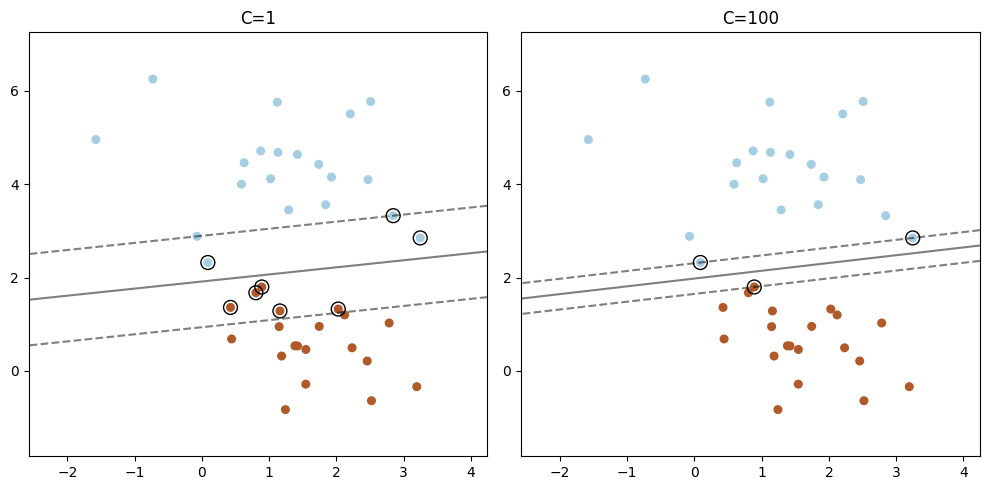

In [35]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)

    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)

    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices] # here we get the support vectors

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

To understand the differences between `SVC` and `LinearSVC` in the context of Support Vector Machines (SVM) in scikit-learn, it's important to recognize that they are designed for similar tasks but have different implementations and characteristics.

## Implementation Differences

1. **Underlying Libraries**:
   - **SVC**: This is implemented using the `libsvm` library, which is a versatile library that supports various kernel functions, including non-linear kernels.
   - **LinearSVC**: This is implemented using the `liblinear` library, which is optimized specifically for linear classification problems. This means it is generally faster and more efficient for large datasets when a linear decision boundary is sufficient[1][4].

2. **Kernel Support**:
   - **SVC**: Allows for the specification of different kernels (e.g., linear, polynomial, RBF), making it suitable for both linear and non-linear classification tasks.
   - **LinearSVC**: Assumes a linear kernel by default and does not support other kernels. This makes it less flexible but more efficient for linear problems[4].

## Performance and Scalability

3. **Scalability**:
   - **LinearSVC** tends to scale better with larger datasets due to its optimization for linear problems. It can handle a larger number of samples more effectively than `SVC`[2][4].

4. **Speed**:
   - In practice, `LinearSVC` is often faster to train than `SVC(kernel='linear')`, especially as the size of the dataset increases. This is because `liblinear` is specifically designed for linear problems, while `libsvm` is more general-purpose and can be slower due to its flexibility[2][3].

## Default Parameters and Behavior

5. **Loss Functions**:
   - **SVC**: By default, it uses the hinge loss function.
   - **LinearSVC**: The default loss function is `squared_hinge`, which can affect the optimization process and the results obtained[1][2][4].

6. **Regularization**:
   - **LinearSVC** includes regularization of the intercept term, which can lead to different results compared to `SVC`, which does not regularize the intercept by default. This difference can significantly impact the model's performance and the decision boundary it learns[1][2][3].

7. **Multi-class Classification**:
   - **SVC**: Typically uses a one-vs-one approach for multi-class classification.
   - **LinearSVC**: Uses a one-vs-rest approach by default, which can influence how the model handles multi-class problems[2][3].

## Conclusion

In summary, while both `SVC` and `LinearSVC` are used for classification tasks, they differ in their implementations, performance characteristics, and default behaviors. `LinearSVC` is more efficient for large datasets with linear decision boundaries, while `SVC` offers more flexibility with kernel options for potentially non-linear classification tasks. Understanding these differences helps in selecting the appropriate model based on the specific requirements of the dataset and the problem at hand.